In [1]:
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize, Emitter, Transitioner, Initializers, Training
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
from learnMSA.protein_language_models import Common, EmbeddingBatchGenerator

2024-10-17 10:31:47.021165: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



# Experimental demo: learnMSA + protein language model

This notebook demonstrates how to align a set of protein sequences with learnMSA supported by a large, pre-trained protein language model.

This configuration of learnMSA - although a prototype - is the most accurate variant of learnMSA currently available. It is also the most computationally expensive. It is recommended to run this notebook on a GPU.

In [2]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 4

HMM training supported by protein embeddings:

In [3]:
def align(filename, out_filename):
    scoring_model_config = Common.ScoringModelConfig(dim=32, lm_name="protT5", activation="softmax", scaled=False)
    config = Configuration.make_default(num_models, 
                                        use_language_model=True, 
                                        scoring_model_config=scoring_model_config,
                                        frozen_insertions=True,
                                        num_prior_components=10,
                                        V2_emitter=True,
                                        V2_temperature=3.)
    #config["batch_size"] = 16
    # we have to define a special model- and batch generator if using a language model
    # because the emission probabilities are computed differently and the LM requires specific inputs
    model_gen = EmbeddingBatchGenerator.make_generic_embedding_model_generator(config["scoring_model_config"].dim)
    batch_gen = EmbeddingBatchGenerator.EmbeddingBatchGenerator(config["scoring_model_config"])
    with SequenceDataset(train_filename, fmt="fasta") as data:
        config["crop_long_seqs"] = int(np.ceil(3 * np.mean(data.seq_lens)))
        alignment_model = Align.run_learnMSA(data,
                                            out_filename,
                                            config, 
                                            model_generator=model_gen,
                                            batch_generator=batch_gen,
                                            sequence_weights=Align.compute_sequence_weights(train_filename, "tmp", config["cluster_seq_id"]),
                                            verbose=True,
                                            align_insertions=True)
    return alignment_model

Training of 4 models on file egf.fasta
Configuration: 
{
num_models : 4
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=10000

/home/beckerf/mambaforge/envs/learnMSAdev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/beckerf/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/beckerf/.local/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `DISABLE_TELEMETRY` is deprecated and will be removed in v5 of Transformers. Use `HF_HUB_DISABLE_TELEMETRY` instead.
  warnings.warn(
/home/beckerf/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._

Computing all embeddings (this may take a while).
10% done.
20% done.
30% done.
40% done.
50% done.
60% done.
70% done.
80% done.
90% done.
100% done.
Fitting models of lengths [27 25 26 25] on 7774 sequences.
Batch size= 100 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.
Epoch 1/10
88/88 - 24s - loss: 73.8051 - loglik: -6.9138e+01 - prior: -3.8049e+00 - aux_loss: 0.8621 - 24s/epoch - 278ms/step
Epoch 2/10
88/88 - 8s - loss: 73.3317 - loglik: -7.0000e+01 - prior: -2.4694e+00 - aux_loss: 0.8623 - 8s/epoch - 95ms/step
Epoch 3/10
88/88 - 9s - loss: 73.2161 - loglik: -7.0122e+01 - prior: -2.2351e+00 - aux_loss: 0.8595 - 9s/epoch - 97ms/step
Epoch 4/10
88/88 - 8s - loss: 71.4124 - loglik: -6.8393e+01 - prior: -2.1565e+00 - aux_loss: 0.8629 - 8s/epoch - 96ms/step
Epoch 5/10
88/88 - 8s - loss: 71.3380 - loglik: -6.8380e+01 - prior: -2.0938e+00 - aux_loss: 0.8640 - 8s/epoch - 96ms/step
Epoch 6/10
88/88 - 8s - 

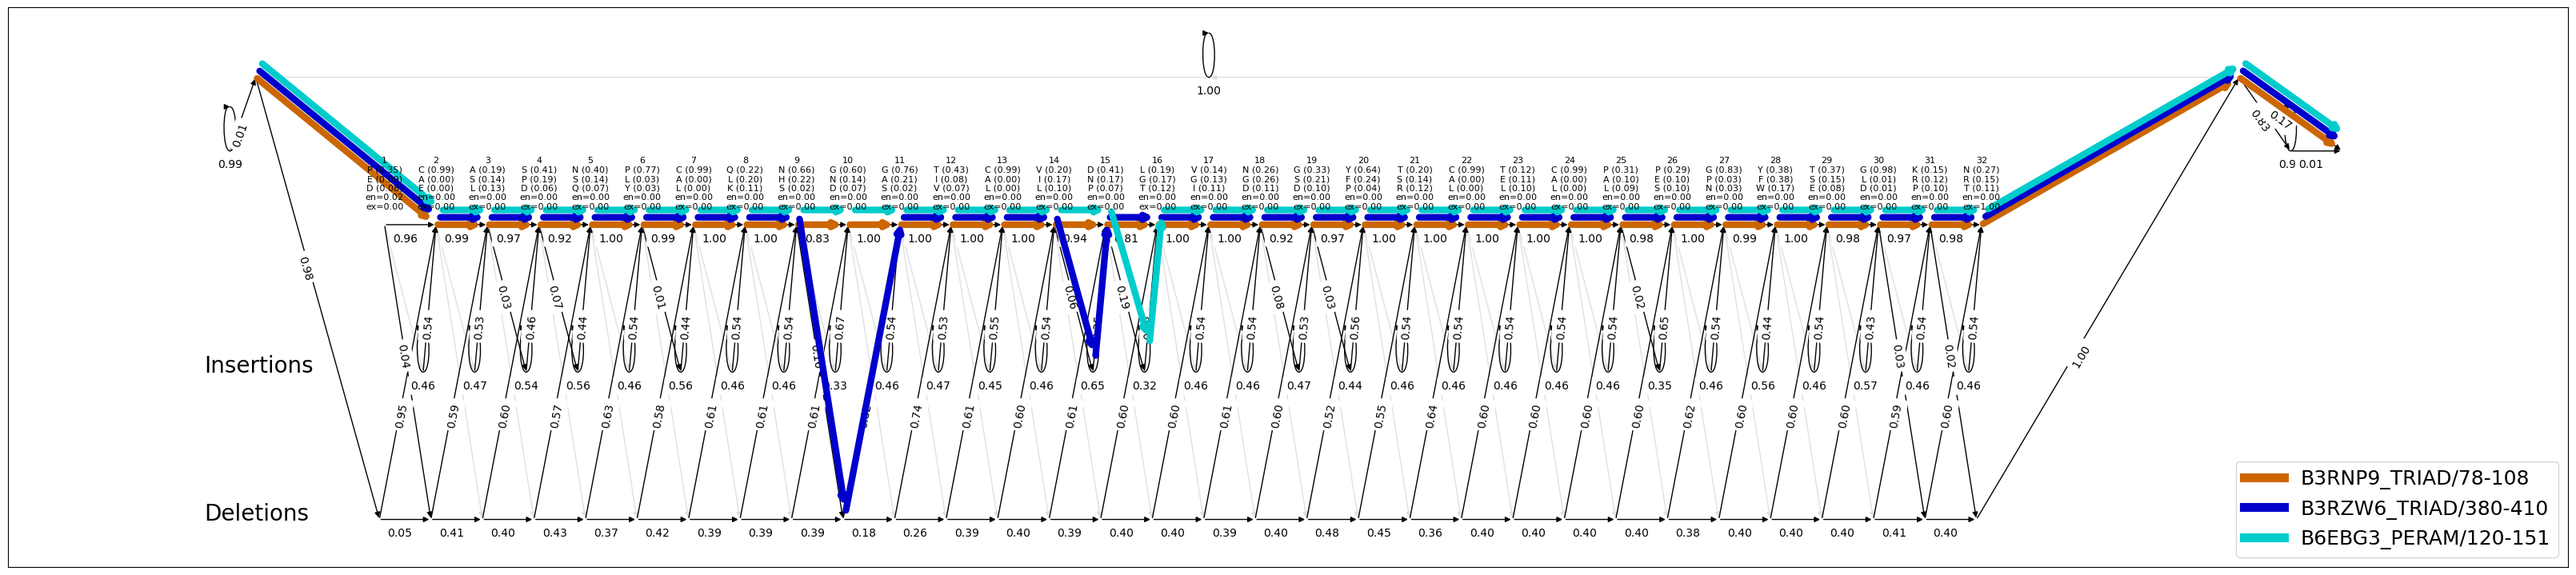

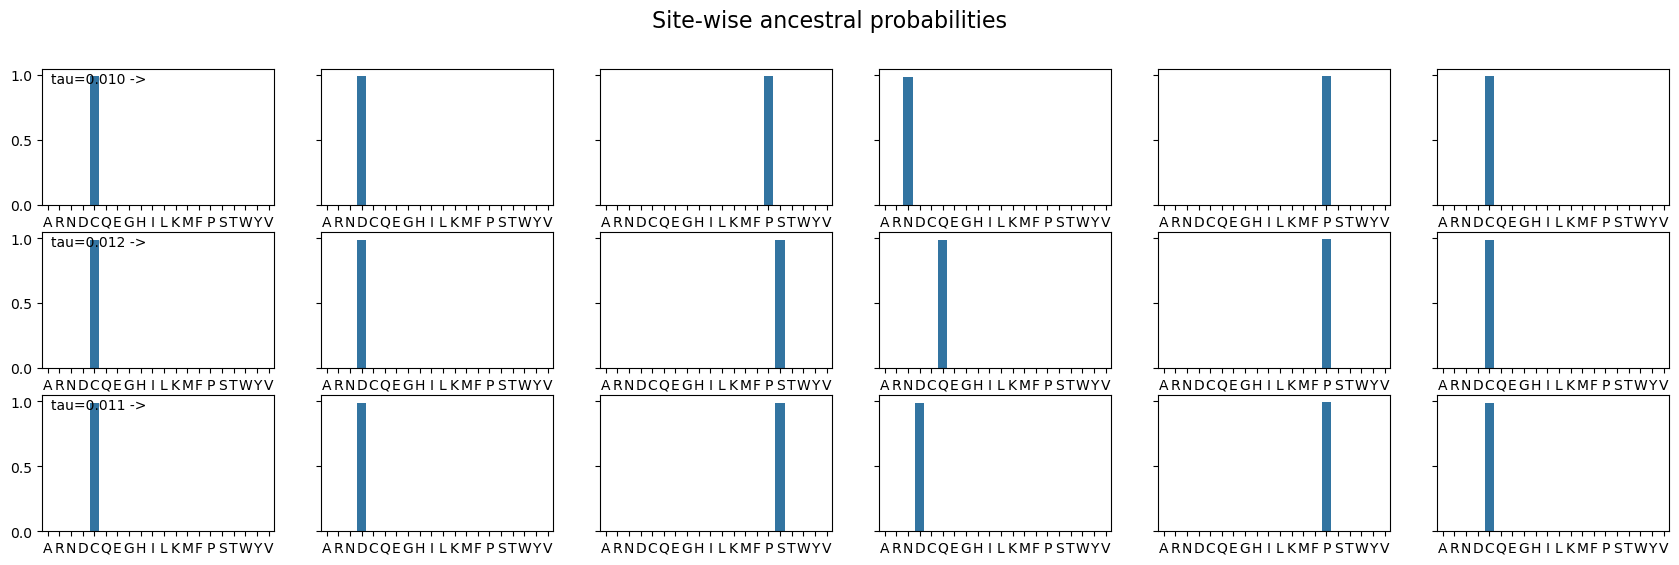

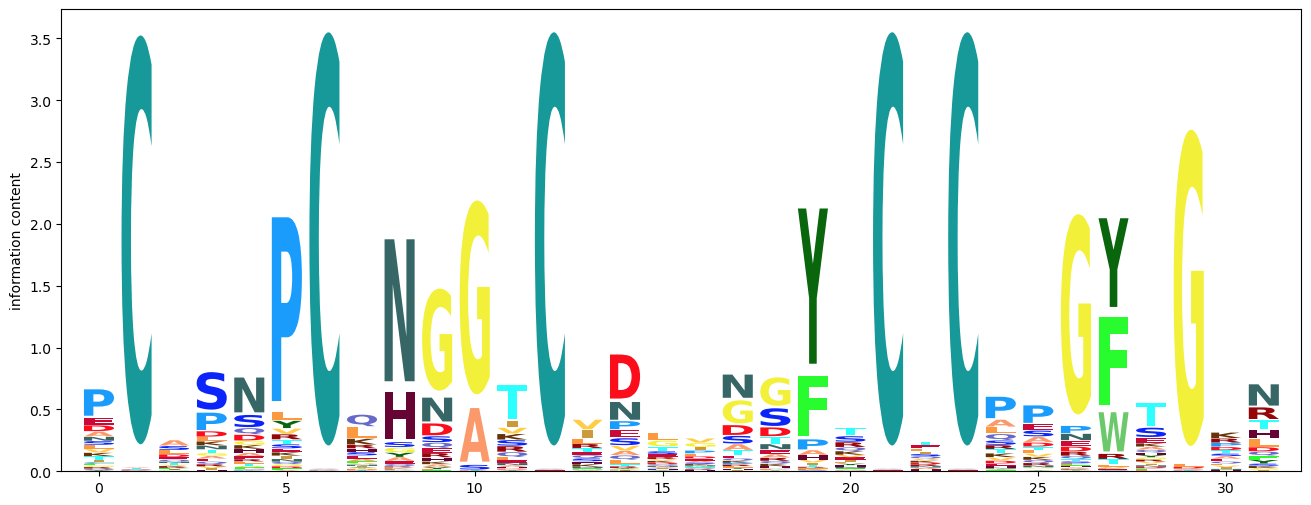

In [4]:
alignment_model = align(train_filename, "test/data/interactive.alignment.fasta") 
Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [5]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1ixa
HERE: 1apo
HERE: 1urk
HERE: 1fsb
HERE: 1esl
HERE: 1hre
HERE: 1epi
HERE: 4tgf
HERE: 1hcgb
HERE: 1dan1
HERE: 1dan2
HERE: 1rfnb


In [6]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
egf           12         31.1    77.5 [100.0]   [ 5182]
